In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, cut_tree
from ISLP.cluster import (
    compute_linkage,
)  # necessite l'installation de l'environnement ISLP

# 聚类（Clustering）

在本次实验中，我们将对一个数据集进行聚类演示。

## 使用模拟数据进行 $K$-均值聚类

`sklearn.cluster.KMeans()` 是 `Python` 中用于执行 $K$-均值聚类的估计器。  
我们从一个简单的模拟示例开始，其中数据中确实存在两个聚类：前25个观测值相对于接下来的25个观测值具有一个均值偏移（mean shift）。

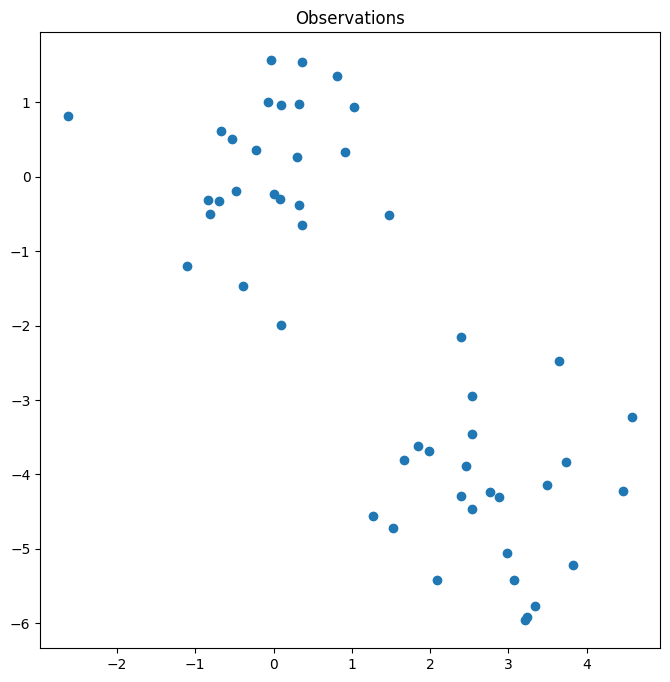

In [2]:
np.random.seed(42)
X = np.random.standard_normal((50, 2))
X[:25, 0] += 3
X[:25, 1] -= 4
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1])
ax.set_title("Observations")
plt.show()

我们现在执行 $K$-均值聚类，设定 $K=2$。

In [3]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20).fit(X)

我们指定 `random_state` 参数以确保结果可重复。50个观测值的聚类分配存储在 `kmeans.labels_` 中。

In [4]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

$K$-均值聚类在未向 `KMeans()` 提供任何组别信息的情况下，完美地将观测值分为两个聚类。我们可以绘制数据图，其中每个观测点根据其聚类分配进行着色。

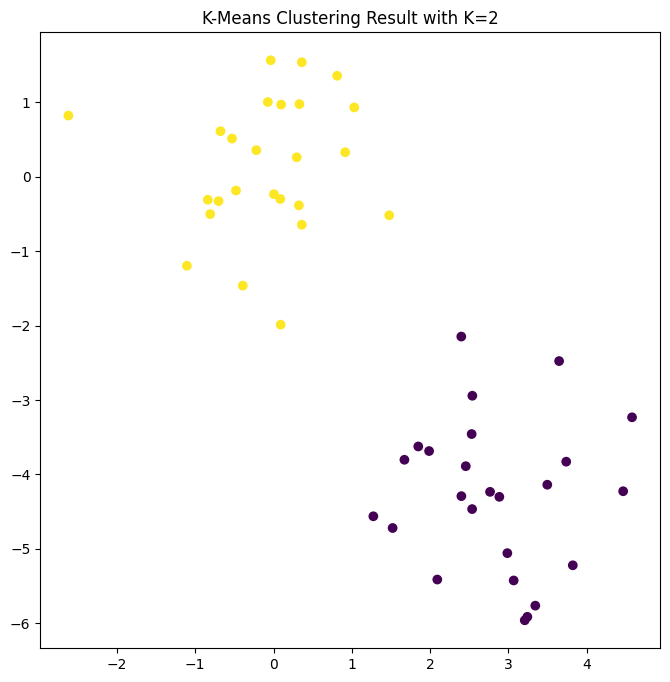

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
ax.set_title("K-Means Clustering Result with K=2")
plt.show()

在这个例子中，由于观测数据是二维的，因此可以轻松绘制其分布图。如果变量多于两个，我们可以先执行主成分分析（PCA），并绘制前两个主成分得分向量，以可视化聚类结果。

在这个示例中，我们知道确实存在两个聚类，因为数据是我们生成的。然而，对于真实数据，我们通常无法提前知道聚类的实际数量，也不确定聚类是否以某种精确方式存在。我们也可以在本例中尝试使用 $K=3$ 执行 $K$-均值聚类。

In [6]:
kmeans1 = KMeans(n_clusters=3, random_state=42, n_init=1).fit(X)
kmeans20 = KMeans(n_clusters=3, random_state=42, n_init=20).fit(X)

kmeans1.inertia_, kmeans20.inertia_

(63.70668423951798, 62.73737809735573)

当 $K=3$ 时，$K$-均值聚类会将原本的两个聚类进一步细分。

我们使用了参数 `n_init` 将 $K$-均值聚类运行了20次不同的初始聚类分配（默认值是10次）。如果 `n_init` 的值大于1，那么在算法 12.2 的第1步中，$K$-均值聚类将使用多个随机初始分配，并且 `KMeans()` 函数仅会报告最佳的聚类结果。以下我们对比 `n_init=1` 和 `n_init=20` 的效果。

In [7]:
kmeans20 = KMeans(n_clusters=3, random_state=42, n_init=20).fit(X)
kmeans2 = KMeans(n_clusters=2, random_state=42, n_init=20).fit(X)

kmeans20.inertia_, kmeans2.inertia_

(62.73737809735573, 79.47078251875006)

需要注意的是，`kmeans.inertia_` 表示聚类内平方和（total within-cluster sum of squares），这是我们在执行 $K$-均值聚类时希望最小化的目标。

我们**强烈建议**在运行 $K$-均值聚类时，将 `n_init` 参数设置为较大的值，例如20或50。否则，可能会陷入不理想的局部最优解。

在执行 $K$-均值聚类时，除了使用多个初始聚类分配，还需要通过 `KMeans()` 的 `random_state` 参数设置随机种子。这确保了第1步的初始聚类分配可以重复，从而使 $K$-均值的输出结果完全可复现。

## 层次聚类（Hierarchical Clustering）

`sklearn.clustering` 包中的 `AgglomerativeClustering()` 类实现了层次聚类（hierarchical clustering）。  
由于其名称较长，我们使用 `HClust` 作为层次聚类的简称。但请注意，这不会改变使用此方法时的返回类型，实例仍属于 `AgglomerativeClustering` 类。

在下面的示例中，我们使用上一实验中的数据，绘制基于欧几里得距离（Euclidean distance）作为相异性度量的层次聚类树状图（dendrogram）。具体方法包括完全链接法（complete linkage）、单链接法（single linkage）和平均链接法（average linkage）。我们首先使用完全链接法对观测值进行聚类。

In [8]:
HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0, n_clusters=None, linkage="complete")
hc_comp.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

这将计算完整的树状图（dendrogram）。 
 
我们也可以轻松地使用平均链接法（average linkage）或单链接法（single linkage）来进行层次聚类，具体方法类似：

In [9]:
hc_avg = HClust(distance_threshold=0, n_clusters=None, linkage="average")
hc_avg.fit(X)

hc_sing = HClust(distance_threshold=0, n_clusters=None, linkage="single")
hc_sing.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='single', n_clusters=None)

要使用预先计算的距离矩阵（precomputed distance matrix），我们需要额外提供参数 `metric="precomputed"`。在下面的代码中，前四行计算了一个 $50 \times 50$ 的成对距离矩阵（pairwise-distance matrix）。

In [10]:
D = np.zeros((X.shape[0], X.shape[0]))
for i in range(X.shape[0]):
    x_ = np.multiply.outer(np.ones(X.shape[0]), X[i])
    D[i] = np.sqrt(np.sum((X - x_) ** 2, 1))
hc_sing_pre = HClust(
    
    distance_threshold=0, n_clusters=None, metric="precomputed", linkage="single"
)
hc_sing_pre.fit(D)

AgglomerativeClustering(distance_threshold=0, linkage='single',
                        metric='precomputed', n_clusters=None)

我们使用 `scipy.cluster.hierarchy` 中的 `dendrogram()` 函数来绘制树状图（dendrogram）。然而，`dendrogram()` 需要一个所谓的*链接矩阵表示法*（linkage-matrix representation），而 `AgglomerativeClustering()` 并不直接提供这种表示方式。为此，我们可以计算它，`ISLP.cluster` 包中的 `compute_linkage()` 函数专门用于这个目的。

接下来，我们可以绘制树状图。绘图底部的数字标识了每个观测点。`dendrogram()` 函数默认会通过不同颜色区分树的分支，这隐含了一种在特定深度切割树的建议。我们倾向于覆盖此默认行为，将阈值设置为无限大。

为了让这种行为可以方便地应用于多个树状图，我们将这些设置存储在一个字典 `cargs` 中，并使用 `**cargs` 的语法将其作为关键字参数传递。

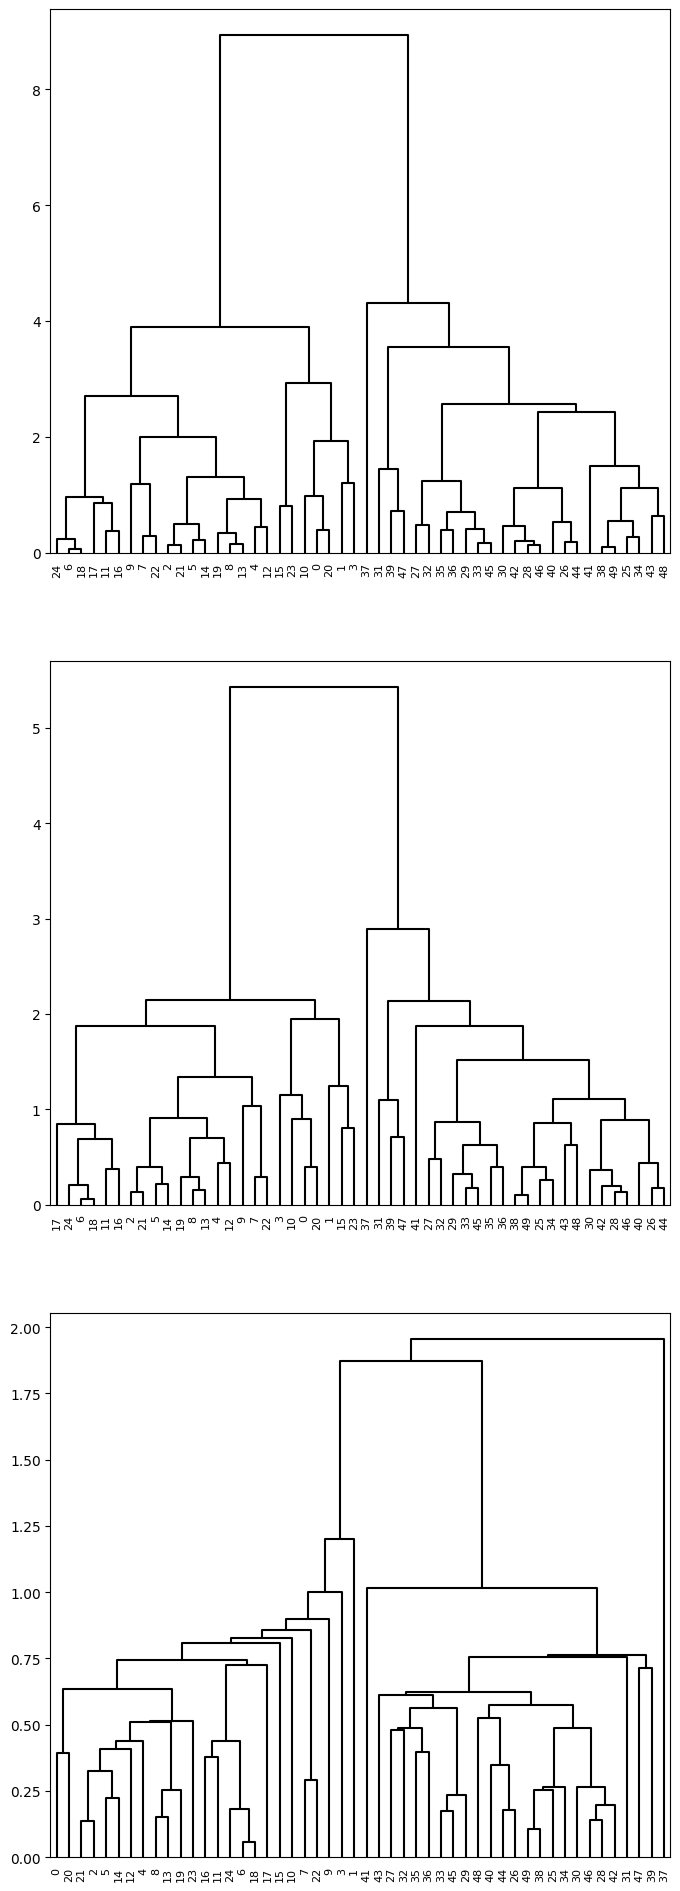

In [11]:
cargs = {"color_threshold": -np.inf, "above_threshold_color": "black"}
linkage_comp = compute_linkage(hc_comp)
linkage_avg = compute_linkage(hc_avg)
linkage_sing = compute_linkage(hc_sing)

fig, axes = plt.subplots(3, 1, figsize=(8, 24))
dendrogram(linkage_comp, ax=axes[0], **cargs)
dendrogram(linkage_avg, ax=axes[1], **cargs)
dendrogram(linkage_sing, ax=axes[2], **cargs)
plt.show()

我们可能希望对树的分支在切割阈值以上和以下部分分别使用不同的颜色。这可以通过调整 `color_threshold` 参数来实现。例如，我们可以在高度为4的地方切割树，并将高度超过4的分支链接颜色设为黑色。

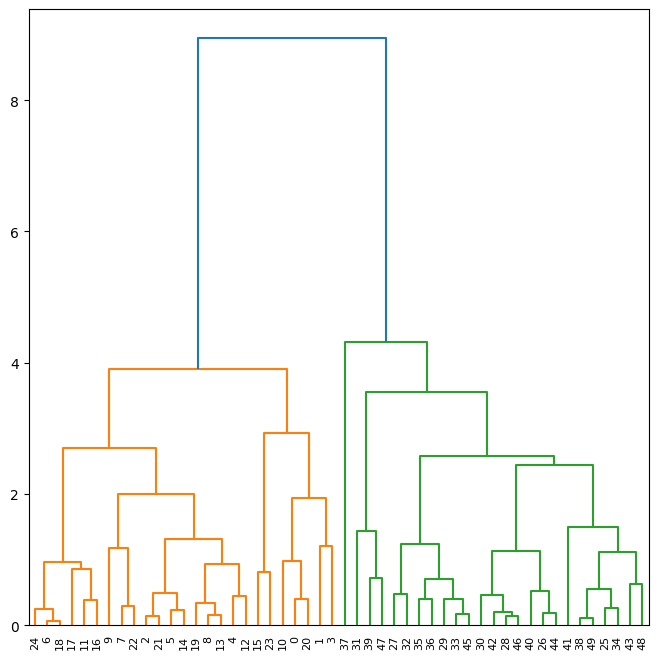

In [12]:
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp, ax=ax)
plt.show()

要确定树状图在指定切割点处每个观测值的聚类标签，可以使用 `scipy.cluster.hierarchy` 中的 `cut_tree()` 函数：

In [13]:
cut_tree(linkage_comp, n_clusters=4).T

array([[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2]])

这也可以通过向 `HClust()` 提供参数 `n_clusters` 来实现；然而，每次切割都需要重新计算聚类。类似地，可以通过向 `HClust()` 提供参数 `distance_threshold` 或向 `cut_tree()` 提供参数 `height` 来根据距离阈值切割树。

In [14]:
cut_tree(linkage_comp, height=5)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

在对观测值进行层次聚类之前，如果需要对变量进行标准化，可以使用 `StandardScaler()`，就像我们在 PCA 示例中那样：

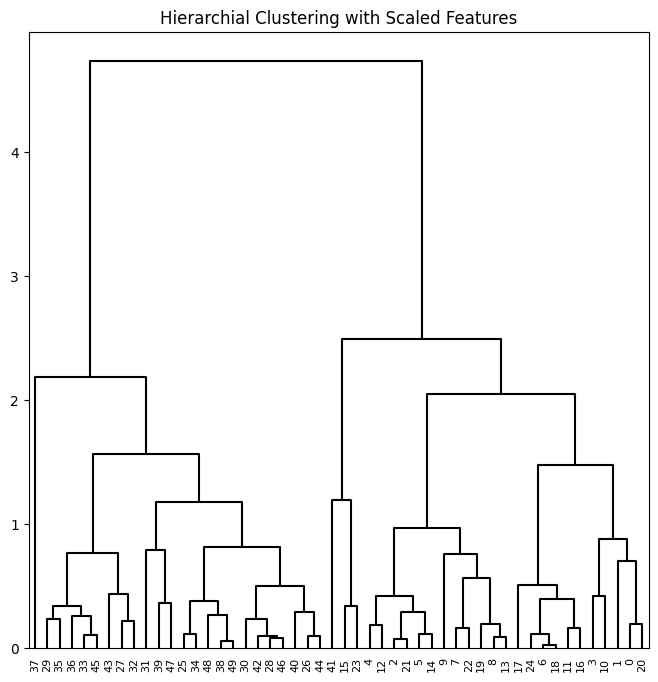

In [15]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
hc_comp_scale = HClust(distance_threshold=0, n_clusters=None, linkage="complete").fit(
    X_scale
)
linkage_comp_scale = compute_linkage(hc_comp_scale)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp_scale, ax=ax, **cargs)
ax.set_title("Hierarchial Clustering with Scaled Features")
plt.show()

基于相关性（correlation）的距离可以用于聚类。两个观测值之间的相关性衡量它们特征值的相似程度。  
{假设每个观测值具有 $p$ 个特征，每个特征是一个数值。我们通过计算这 $p$ 对数值之间的相关性来度量两个观测值的相似性。}

对于 $n$ 个观测值，可以构造一个 $n \times n$ 的相关性矩阵（correlation matrix）作为相似度矩阵（similarity/affinity matrix）。然后，使用 $1 - \text{correlation matrix}$ 作为用于聚类的相异性矩阵（dissimilarity matrix）。

需要注意的是，只有在数据集包含至少三个特征时，相关性才有意义。因为当特征数为两个时，任何两个观测值之间的绝对相关性始终为1。因此，我们将对一个三维数据集进行聚类。